In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 

sns.set(style="white")
df = pd.read_csv("../Data/spam.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
# check how many rows have values in the Unnamed columns
np.sum(df[df.columns[2:].tolist()].notna())

/Users/asajad/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Unnamed: 2    50
Unnamed: 3    12
Unnamed: 4     6
dtype: int64

In [3]:
print(df.shape)
# read some of the Unnamed that have values
df.loc[df["Unnamed: 2"].notna()].iloc[:5]

(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


In [4]:
# as it is very few rows, we remove those columns
df_no_NaN = df.dropna(axis=1)
df_no_NaN.columns = ["class", "content"]
df_no_NaN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   class    5572 non-null   object
 1   content  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<Axes: xlabel='class', ylabel='count'>

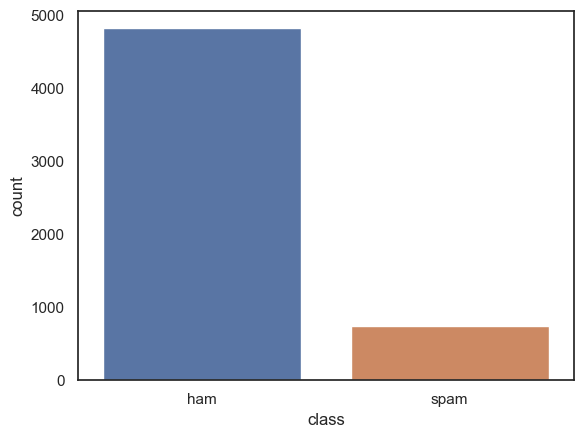

In [5]:
# check balance of spam/ham - this is an unbalanced dataset
sns.countplot(data = df_no_NaN, x = "class")

In [6]:
df = pd.get_dummies(df_no_NaN, columns = ["class"], drop_first=True)
X, y = df["content"], df["class_spam"]
X.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: content, dtype: object

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(X)
print(repr(X_tfidf))
print(X_tfidf[1])
print(f"Min value: {X_tfidf.min()}, max value: {X_tfidf.max()}")

<5572x8404 sparse matrix of type '<class 'numpy.float64'>'
	with 43478 stored elements in Compressed Sparse Row format>
  (0, 5369)	0.5465881710238072
  (0, 8134)	0.43160103626390106
  (0, 4192)	0.5236458071582337
  (0, 4385)	0.40829885619071804
  (0, 5343)	0.2721195132138254
Min value: 0.0, max value: 1.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape

((3733, 8404), (1839, 8404))

<Axes: xlabel='class_spam', ylabel='count'>

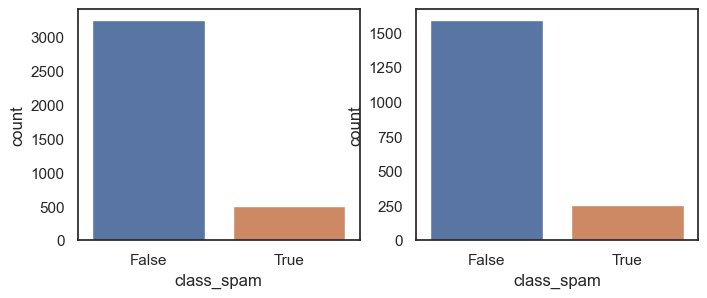

In [9]:
fig, ax = plt.subplots(1,2, dpi = 100, figsize = (8,3))
sns.countplot(x = y_train, ax = ax[0])
sns.countplot(x = y_test, ax = ax[1])

              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1587
        True       1.00      0.75      0.86       252

    accuracy                           0.97      1839
   macro avg       0.98      0.88      0.92      1839
weighted avg       0.97      0.97      0.96      1839



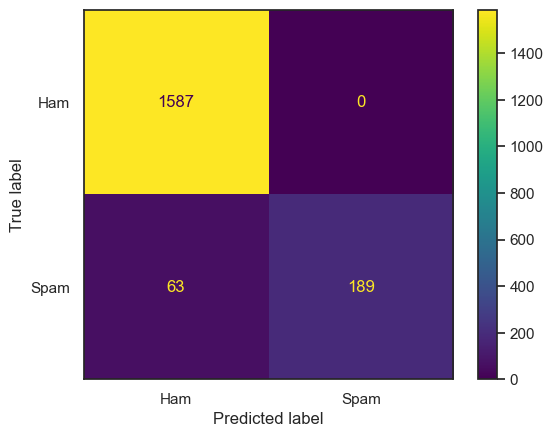

In [10]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

naive_bayes = dict(
    multinomial = MultinomialNB(),
    bernoulli = BernoulliNB(),
    complement = ComplementNB()
)

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"]).plot()

evaluate_model(naive_bayes["multinomial"])

# precision = TP/(TP+FP)
# recall = TP/(TP+FN)
# high precision -> low FP -> low hams in spam box
# high recall -> low FN -> low spams in inbox
# want to have high precision as we don't want to have any hams in spam box
# can accept somewhat lower recall as it's not the end of the world if 
# we get spams in inbox. Ideally both precision and recall are high.

              precision    recall  f1-score   support

       False       0.97      1.00      0.98      1587
        True       0.98      0.81      0.89       252

    accuracy                           0.97      1839
   macro avg       0.97      0.91      0.94      1839
weighted avg       0.97      0.97      0.97      1839



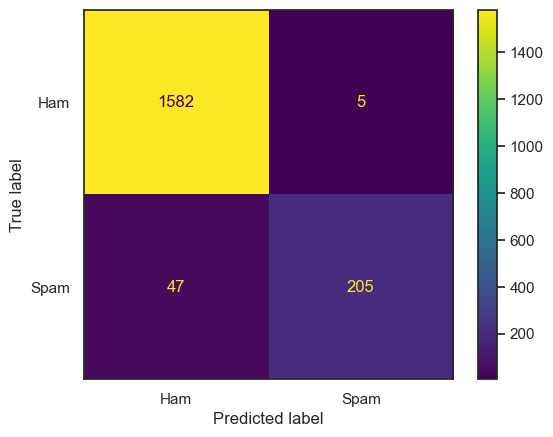

In [11]:
evaluate_model(naive_bayes["bernoulli"])

              precision    recall  f1-score   support

       False       0.99      0.92      0.96      1587
        True       0.66      0.94      0.78       252

    accuracy                           0.93      1839
   macro avg       0.83      0.93      0.87      1839
weighted avg       0.95      0.93      0.93      1839



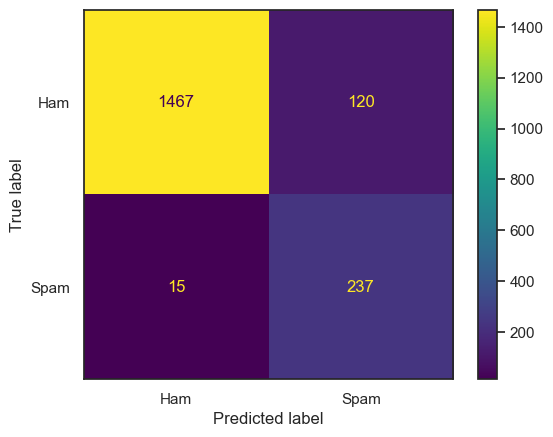

In [12]:
evaluate_model(naive_bayes["complement"])

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1587
        True       0.97      0.85      0.91       252

    accuracy                           0.98      1839
   macro avg       0.97      0.92      0.95      1839
weighted avg       0.98      0.98      0.98      1839



/Users/asajad/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


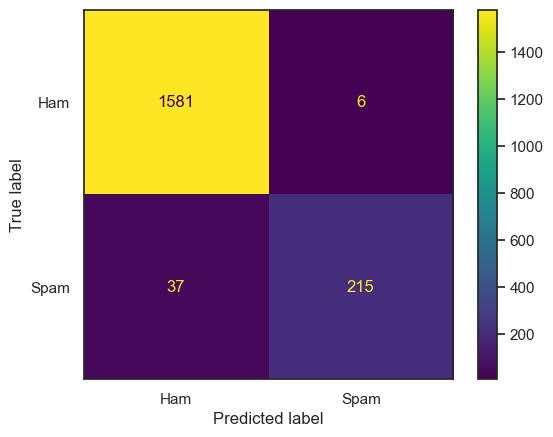

In [13]:
from sklearn.svm import LinearSVC

evaluate_model(LinearSVC())

              precision    recall  f1-score   support

       False       0.97      1.00      0.99      1587
        True       1.00      0.83      0.91       252

    accuracy                           0.98      1839
   macro avg       0.98      0.92      0.95      1839
weighted avg       0.98      0.98      0.98      1839



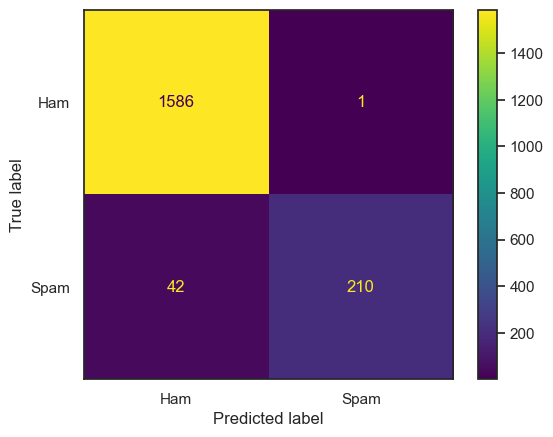

In [14]:
from sklearn.ensemble import RandomForestClassifier

evaluate_model(RandomForestClassifier())

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1587
        True       1.00      0.86      0.92       252

    accuracy                           0.98      1839
   macro avg       0.99      0.93      0.96      1839
weighted avg       0.98      0.98      0.98      1839



/Users/asajad/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


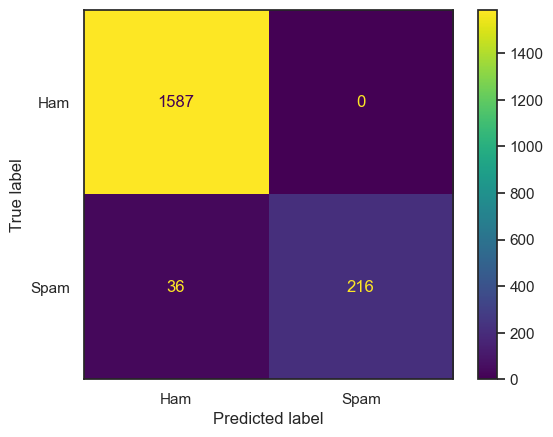

In [15]:
from sklearn.ensemble import VotingClassifier

vote_clf = VotingClassifier(
    [("rf", RandomForestClassifier()),
     ("svc", LinearSVC()),
     ("naive_complement", ComplementNB()),
     ("naive_bernoulli", BernoulliNB()),
     ("naive_multinomail", MultinomialNB())], voting="hard")

evaluate_model(vote_clf)

# we see that a combination of models improves the performance

In [16]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [("tfidf", TfidfVectorizer(stop_words="english")), ("vote", vote_clf)])

# fits on all data
pipe.fit(X, y)
pipe.predict(["Come and collect your $1000 Bitcoins!"])
# 0 is ham and 1 is spam

/Users/asajad/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([False])

In [18]:
pipe.predict(["You will win, $1000 for free"])

array([ True])

In [19]:
pipe.predict(["You get $500"])

array([ True])